# Evidential Deep Learning with Pytorch
This example will implement the paper "Evidential Deep Learning to Quantify Classification Uncertainty" on Pytorch.
#### References
* [Baseline MNIST train with Pytorch](https://nextjournal.com/gkoehler/pytorch-mnist)
* [Tensorboard Dev](https://tensorboard.dev/#get-started)
* [Lecture](https://www.youtube.com/watch?v=DzQ202Mak8I)

In [1]:
import mnist_data_pytorch as data
import evd_dl_plot as plot_utils
import matplotlib.pyplot as plt
import evd_losses as evd_loss
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Pytorch version:', torch.__version__)
# Tensorboard
from torch.utils.tensorboard import SummaryWriter
!rm -rf ./runs
writer = SummaryWriter('./runs/train')

# Metaparameters
num_epochs = 30
num_classes = 10

Device: cuda:0
Pytorch version: 1.2.0


#### Display some samples

Data shape: torch.Size([1000, 1, 28, 28])


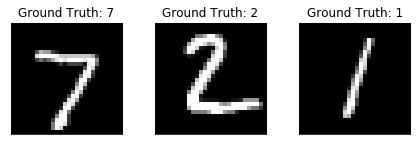

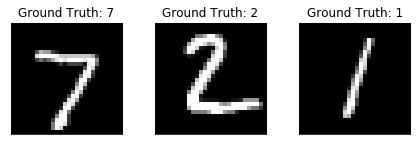

In [2]:
examples = enumerate(data.dataloaders['val'])
batch_idx, (example_data, example_targets) = next(examples)
print('Data shape:', example_data.shape)
fig = plt.figure()
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

#### Some helper functions

In [3]:
def one_hot(labels, num_classes=10):
    """
    Convert labels to one_hot_encoding
    """
    # Convert to One Hot Encoding
    y = torch.eye(num_classes)
    return y[labels]

#### Define Model

In [4]:
class LeNet(nn.Module):
    def __init__(self, dropout=True, num_classes=10):
        super().__init__()
        self.use_dropout = dropout
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5)
        self.fc1 = nn.Linear(20000, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 1))
        x = F.relu(F.max_pool2d(self.conv2(x), 1))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        if self.use_dropout:
            x = F.dropout(x, training=self.training)
        
        # logits (positive or negative numbers)
        logits = self.fc2(x)
        # Changes
        evidence = F.relu(logits)
        alpha = evidence + 1
        uncertainty = self.num_classes / torch.sum(alpha, dim=1, keepdim=True)
        return logits, evidence, alpha, uncertainty

model = LeNet()
writer.add_graph(model, example_data)
model = model.to(device)

#### Define Loss Function

In [5]:
criterion = evd_loss.edl_mse_loss

#### Define Optimizer and Learning Rate Scheduler

In [6]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#### Test Model helper

In [7]:
def test_model(model, criterion, dataloader_test):
    model.eval()
    test_loss = 0
    correct = 0
    running_loss = 0.0
    running_corrects = 0.0
    running_uncertainty = 0.0
    with torch.no_grad():
        # Iterate over the data
        for idx_sample, (inputs, labels) in enumerate(dataloader_test):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Convert y to one-hot and send to GPU
            y = one_hot(labels)
            y = y.to(device)
            logits, evidence, alpha, uncertainty = model(inputs)
            _, preds = torch.max(logits, 1)
            # Calculate loss
            loss = criterion(logits, y.float(), evidence, alpha, epoch, num_classes, 10, device)

            match = torch.reshape(torch.eq(preds, labels).float(), (-1, 1))
            acc = torch.mean(match)

            total_evidence = torch.sum(evidence, 1, keepdim=True)
            mean_evidence = torch.mean(total_evidence)
            mean_evidence_succ = torch.sum(torch.sum(evidence, 1, keepdim=True) * match) / torch.sum(match + 1e-20)
            mean_evidence_fail = torch.sum(torch.sum(evidence, 1, keepdim=True) * (1 - match)) / (torch.sum(torch.abs(1 - match)) + 1e-20)

            # Update statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            running_uncertainty += torch.sum(uncertainty)

    epoch_loss = running_loss / len(dataloader_test.dataset)
    epoch_acc = running_corrects.double() / len(dataloader_test.dataset)
    epoch_uncertainty = running_uncertainty.double() / len(dataloader_test.dataset)
    return epoch_loss, epoch_acc.item(), epoch_uncertainty.item()

#### Train Model

In [8]:
losses = {"loss": [], "phase": [], "epoch": []}
accuracy = {"accuracy": [], "phase": [], "epoch": []}
for epoch in tqdm(range(num_epochs)):
    model.train() 
    running_loss = 0.0
    running_corrects = 0.0
    running_uncertainty = 0.0
    # Iterate over the data
    for idx_sample, (inputs, labels) in enumerate(data.dataloaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # Convert y to one-hot and send to GPU
        y = one_hot(labels)
        y = y.to(device)
        logits, evidence, alpha, uncertainty = model(inputs)
        _, preds = torch.max(logits, 1)
        # Calculate loss
        loss = criterion(logits, y.float(), evidence, alpha, epoch, num_classes, 10, device)

        match = torch.reshape(torch.eq(preds, labels).float(), (-1, 1))
        acc = torch.mean(match)

        total_evidence = torch.sum(evidence, 1, keepdim=True)
        mean_evidence = torch.mean(total_evidence)
        mean_evidence_succ = torch.sum(torch.sum(evidence, 1, keepdim=True) * match) / torch.sum(match + 1e-20)
        mean_evidence_fail = torch.sum(torch.sum(evidence, 1, keepdim=True) * (1 - match)) / (torch.sum(torch.abs(1 - match)) + 1e-20)
        
        loss.backward()
        optimizer.step()
        # Update statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_uncertainty += torch.sum(uncertainty)
    
    # Epoch end
    scheduler.step()
    epoch_loss = running_loss / len(data.dataloaders['train'].dataset)
    epoch_acc = running_corrects.double() / len(data.dataloaders['train'].dataset)
    epoch_uncertainty = running_uncertainty.double() / len(data.dataloaders['train'].dataset)
    
    # Send results to tensorboard
    writer.add_scalar('train/loss', epoch_loss, epoch)
    writer.add_scalar('train/accuracy', epoch_acc.item(), epoch)
    writer.add_scalar('train/uncertainty', epoch_uncertainty.item(), epoch)
    
    # Validate on current epoch
    val_loss, val_acc, val_uncertainty = test_model(model, criterion, data.dataloaders['val'])
    writer.add_scalar('val/loss', val_loss, epoch)
    writer.add_scalar('val/accuracy', val_acc, epoch)
    writer.add_scalar('val/uncertainty', val_uncertainty, epoch)

100%|██████████| 30/30 [02:10<00:00,  4.33s/it]


In [9]:
def test_model_interactive(digit_index):
    model.eval()
    some_digit = example_data[digit_index]
    with torch.no_grad():
        logits, evidence, alpha, uncertainty = model(some_digit.unsqueeze(0).to(device))
        _, preds = torch.max(logits, 1)
    predicted_class = preds.item()
    uncertainty = uncertainty.item()
    plt.imshow(some_digit.squeeze(0))
    plt.title('Class:' + str(predicted_class) + ' uncertainty:' + str(uncertainty))
    
    plot_utils.rotating_image_classification(model, example_data[digit_index], device)

In [10]:
interact(test_model_interactive, digit_index=widgets.IntSlider(min=0, max=30, step=1, value=0));

interactive(children=(IntSlider(value=0, description='digit_index', max=30), Output()), _dom_classes=('widget-…

Classifications:
 [1, 1, 1, 1, 1, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 1, 1, 1, 1]


<Figure size 446.4x360 with 0 Axes>

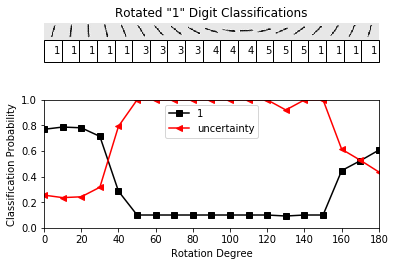

In [22]:
plot_utils.rotating_image_classification(model, example_data[2], device)

#### Try completly different image
Here with a totally different image (baby yoda) the model say some class (ie: 8) but the uncertainty is high, so we can discard it.

torch.Size([1, 1, 28, 28])

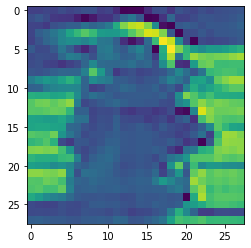

In [20]:
from PIL import Image
img = np.asarray(Image.open("BabyYoda_small.jpg").convert('L'))
plt.imshow(img)
img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)
img.shape

Classifications:
 [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0]


<Figure size 446.4x360 with 0 Axes>

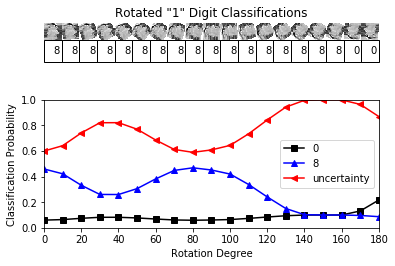

In [21]:
plot_utils.rotating_image_classification(model, img, device, threshold=0.2)